# 4. Text Analysis

In [1]:
import pandas as pd
import numpy as np
import datetime
from pandasql import sqldf
import matplotlib.pyplot as plt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

In [2]:
coffee_business = pd.read_csv("Cleaned\yelp_business_cleaned.csv")
coffee_tip = pd.read_csv("Cleaned\yelp_tip_cleaned.csv")
coffee_review = pd.read_csv("Cleaned\yelp_review_cleaned.csv")
coffee_user = pd.read_csv("Cleaned\yelp_user_cleaned.csv")
coffee_hours = pd.read_csv("Cleaned\yelp_hours_cleaned.csv")

In [3]:
coffee_tip['date'] = pd.to_datetime(coffee_tip['date'])
coffee_review['date'] = pd.to_datetime(coffee_review['date'])
coffee_user['yelping_since'] = pd.to_datetime(coffee_user['yelping_since'])

First, I load the stop words to remove them from the texts of the reviews.

In [5]:
stop = stopwords.words('english')
stop.extend(["i'm", "i've", '-', ''])

In [6]:
no_sw = coffee_review.text.apply(lambda word: (word.lower() for word in word.split(' ') if word.lower() not in stop))

Then I create a dictionary with the appearances of the words in all the reviews. 

In [7]:
def countWords(words):
    corpus = []
    for ea in words:
        corpus += ea 
    wordDict = Counter(corpus)
    return wordDict
wordDict = countWords(no_sw)

Now I sort them by appearances, and I can see frequent words that can help the analysis, like coffee, place, service, food, time and tea. 

In [8]:
[(k, v) for k, v in sorted(wordDict.items(), key = lambda item: item[1], reverse = True)][:20]

[('place', 193546),
 ('coffee', 191311),
 ('like', 144933),
 ('great', 133874),
 ('get', 126115),
 ('good', 125432),
 ('one', 118596),
 ('food', 111573),
 ('really', 102589),
 ('would', 91435),
 ('time', 91016),
 ('go', 90881),
 ('also', 86348),
 ('service', 84280),
 ('love', 83978),
 ('back', 81557),
 ('tea', 80127),
 ('got', 78000),
 ('always', 73664),
 ('little', 69532)]

Then I want to see if there is a variation in the reviews depending on the year. 

In [9]:
review_2008 = sqldf("SELECT text, date FROM coffee_review WHERE STRFTIME('%Y',date) = '2008'")
review_2009 = sqldf("SELECT text, date FROM coffee_review WHERE STRFTIME('%Y',date) = '2009'")
review_2010 = sqldf("SELECT text, date FROM coffee_review WHERE STRFTIME('%Y',date) = '2010'")
review_2011 = sqldf("SELECT text, date FROM coffee_review WHERE STRFTIME('%Y',date) = '2011'")
review_2012 = sqldf("SELECT text, date FROM coffee_review WHERE STRFTIME('%Y',date) = '2012'")
review_2013 = sqldf("SELECT text, date FROM coffee_review WHERE STRFTIME('%Y',date) = '2013'")
review_2014 = sqldf("SELECT text, date FROM coffee_review WHERE STRFTIME('%Y',date) = '2014'")
review_2015 = sqldf("SELECT text, date FROM coffee_review WHERE STRFTIME('%Y',date) = '2015'")
review_2016 = sqldf("SELECT text, date FROM coffee_review WHERE STRFTIME('%Y',date) = '2016'")
review_2017 = sqldf("SELECT text, date FROM coffee_review WHERE STRFTIME('%Y',date) = '2017'")
review_2018 = sqldf("SELECT text, date FROM coffee_review WHERE STRFTIME('%Y',date) = '2018'")
review_2019 = sqldf("SELECT text, date FROM coffee_review WHERE STRFTIME('%Y',date) = '2019'")

In [10]:
def calc_and_display_wc(df_in):
    df = df_in.copy()
    df['text_no_sw'] = df.text.apply(lambda word: [word.lower() for word in word.split(' ') if word.lower() not in stop])
    year_corpus = []
    for ea in df.text_no_sw:
        year_corpus += ea
    wordDict = Counter(year_corpus)
    wordcloud = WordCloud().generate_from_frequencies(wordDict)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

Reviews from 2008


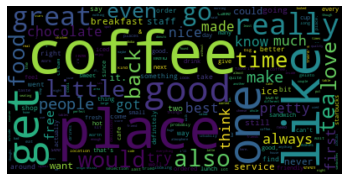

Reviews from 2009


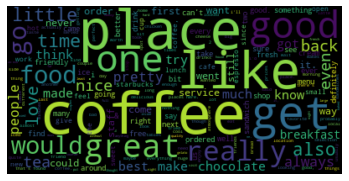

Reviews from 2010


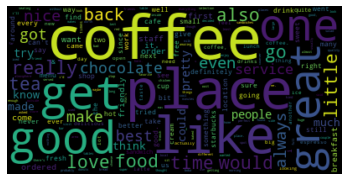

Reviews from 2011


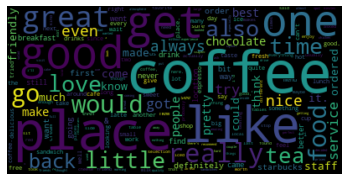

Reviews from 2012


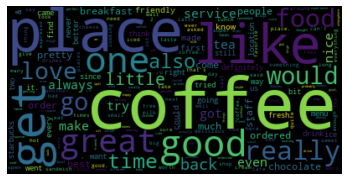

Reviews from 2013


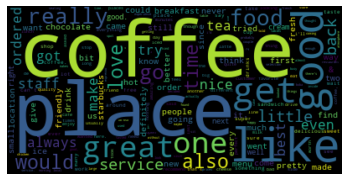

Reviews from 2014


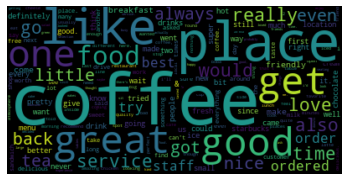

Reviews from 2015


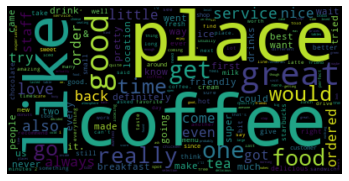

Reviews from 2016


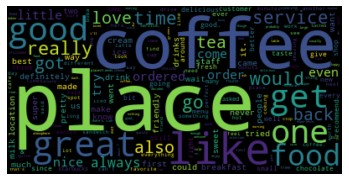

Reviews from 2017


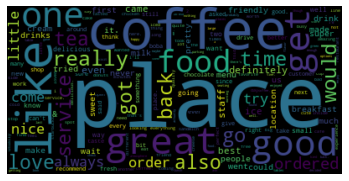

Reviews from 2018


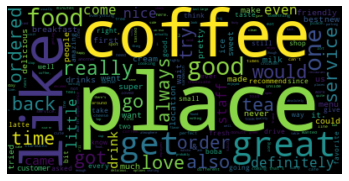

Reviews from 2019


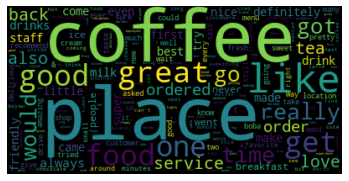

In [12]:
for year in range(2008, 2020):
    df_name = 'review_' + str(year)
    print('Reviews from', year)
    calc_and_display_wc(eval(df_name))

From these Wordclouds, I can take out some words related to food, beverages, service, or the place. However,  I cannot tell the opinion of people about those words. To get more insight into this matter, I create a sentiment variable.

In [13]:
coffee_review['sentiment'] = coffee_review.text.apply(lambda text: TextBlob(text).sentiment[0])

Then I calculated the correlation between the variables in the review table and saw a strong correlation between sentiment and review stars. That means that a positive review should have both a sentiment near one and a high number of stars.  Therefore, I divide positive and negative reviews according to these variables. 

In [14]:
coffee_review.corr(method ='pearson')

,review_stars,useful,funny,cool,sentiment
review_stars,1.000000,-0.015656,-0.022190,0.043866,0.635490
useful,-0.015656,1.000000,0.895494,0.944511,-0.048435
funny,-0.022190,0.895494,1.000000,0.917189,-0.048154
cool,0.043866,0.944511,0.917189,1.000000,-0.007656
sentiment,0.635490,-0.048435,-0.048154,-0.007656,1.000000


In [15]:
positive_reviews = sqldf("""
    SELECT 
        *
    FROM 
        coffee_review 
    WHERE 
        sentiment > 0.3
    AND 
        review_stars > 4

""")
negative_reviews = sqldf("""
    SELECT 
        *
    FROM 
        coffee_review 
    WHERE 
        sentiment < 0
    AND 
        review_stars < 3

""")
print(len(coffee_review), len(positive_reviews), len(negative_reviews))


438009 128700 41465


Then I plot the Wordcloud for each group. 

In [16]:
positive_words = positive_reviews.text.apply(lambda word: (word.lower() for word in word.split(' ') if word.lower() not in stop))
negative_words = negative_reviews.text.apply(lambda word: (word.lower() for word in word.split(' ') if word.lower() not in stop))
positive_wordDict = countWords(positive_words)
negative_wordDict = countWords(negative_words)

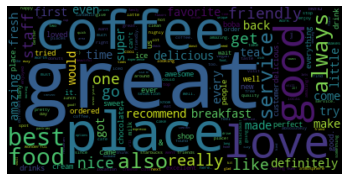

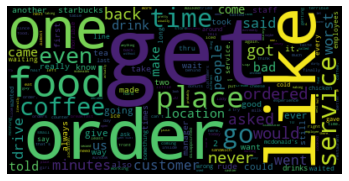

In [17]:
calc_and_display_wc(positive_reviews)
calc_and_display_wc(negative_reviews)

I create the average sentiment and time reviewed variables to see if there is a relation between them and the factor a business closed. 

In [18]:
coffee_sentiment = sqldf("""
    SELECT 
        business_id,
        MAX(STRFTIME('%Y',date)) - MIN(STRFTIME('%Y',date)) AS time_reviewed, 
        AVG(sentiment) AS sentiment,
        COUNT(*) AS reviews
        
    FROM 
        coffee_review
    GROUP BY 
        business_id

""")

In [19]:
business_sentiment = sqldf("""
    SELECT *
    FROM 
        coffee_business AS b
    INNER JOIN 
        coffee_sentiment AS s
    ON 
        b.business_id = s.business_id

""")

In [20]:
business_sentiment = sqldf("""
    SELECT 
        s.is_open, 
        s.time_reviewed,
        averages.sentiment,
        averages.reviews,
        s.stars
        
    FROM
        (SELECT
            business_id,
            AVG(sentiment) AS sentiment,
            AVG(reviews) AS reviews
    
        FROM 
            business_sentiment 
        GROUP BY 
            business_id
        ) AS averages
    INNER JOIN
       business_sentiment AS s
    ON 
        s.business_id = averages.business_id

""")
business_sentiment.head()

,is_open,time_reviewed,sentiment,reviews,stars
0,0,1,0.164913,8.0,2.5
1,1,3,0.233393,5.0,3.5
2,1,4,0.222881,5.0,3.0
3,1,7,0.279410,8.0,3.0
4,1,10,0.300289,63.0,4.0


In [21]:
business_sentiment.corr(method ='pearson')

,is_open,time_reviewed,sentiment,reviews,stars
is_open,1.000000,0.212588,-0.157782,0.080269,-0.147339
time_reviewed,0.212588,1.000000,-0.188839,0.194376,-0.216490
sentiment,-0.157782,-0.188839,1.000000,0.165847,0.848697
reviews,0.080269,0.194376,0.165847,1.000000,0.154101
stars,-0.147339,-0.216490,0.848697,0.154101,1.000000


I create topics for positive and negative reviews to see a possible form of grouping words from the texts. I also give my interpretation of both groups. 

In [22]:
positive_text = positive_reviews.text.apply(lambda word:" ".join([word.lower() for word in word.split(' ') if word.lower() not in stop]))
bow = CountVectorizer()
pos_X = bow.fit_transform(positive_text)

In [23]:
index2word = np.array(bow.get_feature_names())
nmf = NMF(n_components = 7, solver = 'mu')
W = nmf.fit_transform(pos_X)
H = nmf.components_
for i, topic in enumerate(H):
    print("Topic Cluster {}: {}".format(i + 1, ",".join([str(term) for term in index2word[topic.argsort()[-15:]]])))

Topic Cluster 1: friendly,service,try,it,get,go,back,time,like,also,amazing,one,best,food,delicious
Topic Cluster 2: area,atmosphere,local,starbucks,shops,beans,work,staff,iced,espresso,friendly,cup,latte,shop,coffee
Topic Cluster 3: prices,experience,excellent,selection,location,awesome,customer,spot,breakfast,atmosphere,staff,friendly,food,service,great
Topic Cluster 4: highly,hang,staff,work,out,favorite,cute,boba,clean,friends,awesome,recommend,nice,love,place
Topic Cluster 5: best,get,green,ice,great,bubble,like,sweet,also,teas,drinks,drink,milk,boba,tea
Topic Cluster 6: boba,little,tried,milk,drinks,like,great,too,also,got,pretty,nice,place,really,good
Topic Cluster 7: starbucks,drinks,it,every,go,location,here,favorite,get,staff,friendly,good,vesta,always,love


#### Interpretation

1. Service and food.
2. Atmosphere and beverages.
3. Experience.
4. Place.
5. Beverages
6. Place and drinks.
7. Staff.

In [24]:
neg_text = negative_reviews.text.apply(lambda word:" ".join([word.lower() for word in word.split(' ') if word.lower() not in stop]))
bow = CountVectorizer()
neg_X = bow.fit_transform(neg_text)

In [25]:
index2word = np.array(bow.get_feature_names())
nmf = NMF(n_components = 7, solver = 'mu')
W = nmf.fit_transform(neg_X)
H = nmf.components_
for i, topic in enumerate(H):
    print("Topic Cluster {}: {}".format(i + 1, ",".join([str(term) for term in index2word[topic.argsort()[-15:]]])))

Topic Cluster 1: never,people,drink,got,would,go,ordered,it,even,place,back,time,get,like,one
Topic Cluster 2: black,espresso,cream,get,barista,latte,place,drink,shop,milk,like,iced,cup,starbucks,coffee
Topic Cluster 3: waiting,mcdonald,always,wait,go,line,window,minutes,wrong,time,location,get,thru,drive,order
Topic Cluster 4: waited,breakfast,fast,time,get,good,restaurant,mcdonald,wait,order,place,service,minutes,cold,food
Topic Cluster 5: never,ordered,went,service,would,manager,table,order,back,came,told,minutes,asked,said,us
Topic Cluster 6: terrible,slow,drive,employees,one,never,bad,horrible,ever,starbucks,worst,rude,location,customer,service
Topic Cluster 7: ice,bad,bubble,tasted,taste,service,green,drinks,order,drink,like,boba,milk,place,tea


#### Interpretation

1. Time and drinks. 
2. Beverages. 
3. Drive thru. 
4. Waiting time. 
5. Service.
6. Employee service.  
7. Beverages. 

### Notes

1. We need a deeper analysis to see if there is a difference between the opinion about coffee shops over the years. 
2. There is a weak correlation between the is_open variable and the sentiment or time_reviewed variables. That means other factors can explain why a business closed. 
3. Both positive and negative reviews speak about different drinks and the service. 
4. Positive reviews speak more about food and the atmosphere of the place than negative reviews.
5. Negative reviews speak more about waiting time and drive-thru service. 